# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Данные  в столбцах**

- *id* — уникальный идентификатор скважины;
- *f0, f1, f2* — три признака точек (неважно, что они означают, но сами признаки значимы);
- *product* — объём запасов в скважине (тыс. баррелей).

**Условия**

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import time as t

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error 


Для начала выгрузим данные

In [2]:
df_0 = pd.read_csv('/datasets/geo_data_0.csv')
df_1 = pd.read_csv('/datasets/geo_data_1.csv')
df_2 = pd.read_csv('/datasets/geo_data_2.csv')

Теперь базовое исследование данных и поик потенциальных проблем

In [3]:
df_0.info()
df_1.info()
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null 

In [4]:
df_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
df_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
df_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Пропусков в данных нет, идём дальше

In [7]:
print(df_0.describe())
print(df_1.describe())
print(df_2.describe())

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%       

- По условиям задания, точного определения того, что означают параметры *f0,f1,f2* - не дано;
- Тем не менее, все эти параметры находятся в целом в близких размерностях, для анализа нас они устроят;

Так же из данных требуется удалить столбец *id*, т.к. для обучения модели он несет никакого смысла.

In [8]:
df_0 = df_0.drop('id',axis =1)
df_1 = df_1.drop('id',axis =1)
df_2 = df_2.drop('id',axis =1)

> Посмотрим так же матрицу корреляции(вообще,если все параметры значимые,их исключить мы не можем, 
но общая картина станет яснее), а также нормальность распределения величин.

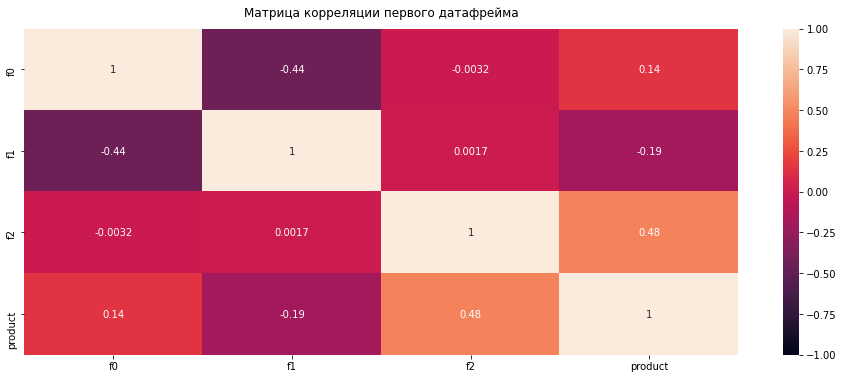

In [9]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_0.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Матрица корреляции первого датафрейма', fontdict={'fontsize':12}, pad=12);

- В первом датафрейме мы наблюдаем слабую обратную корреляцию значений *f0 и f1*, а так же слабую прямую корреляцию *product и f2*;
- Остальные значения не имеют особой корреляции.

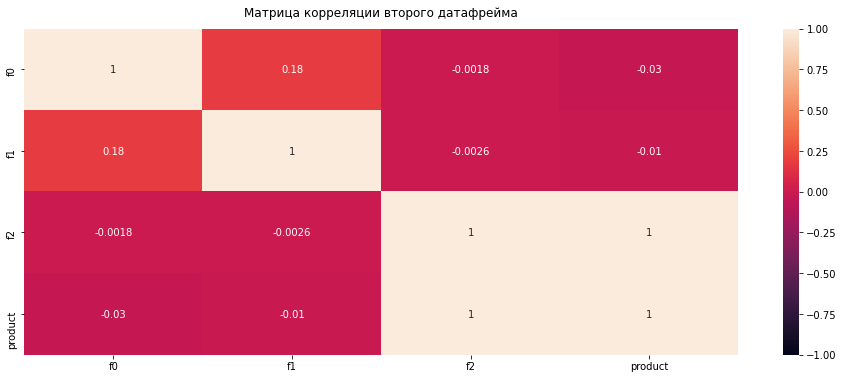

In [10]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_1.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Матрица корреляции второго датафрейма', fontdict={'fontsize':12}, pad=12);

- Здесь мы видим прямую зависимость *f2 и product*,кроме этого зависимостей не обнаружено.

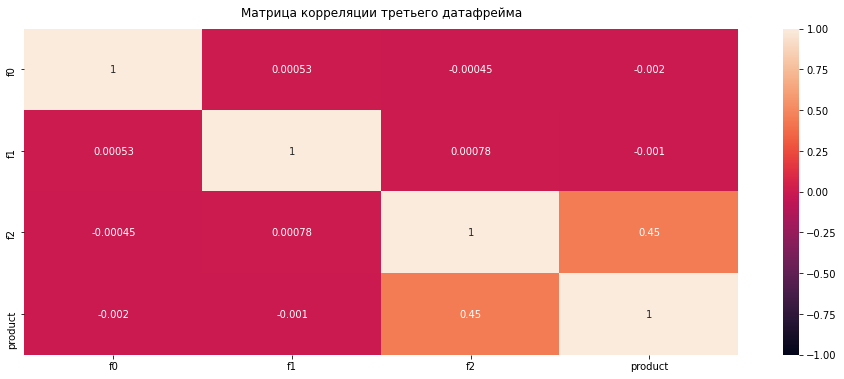

In [11]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_2.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Матрица корреляции третьего датафрейма', fontdict={'fontsize':12}, pad=12);

- Есть слабо выраженная прямая корреляция *f2 и product*,кроме этого зависимостей не обнаружено.

Посмотрим на нормальность распределения целевого признака

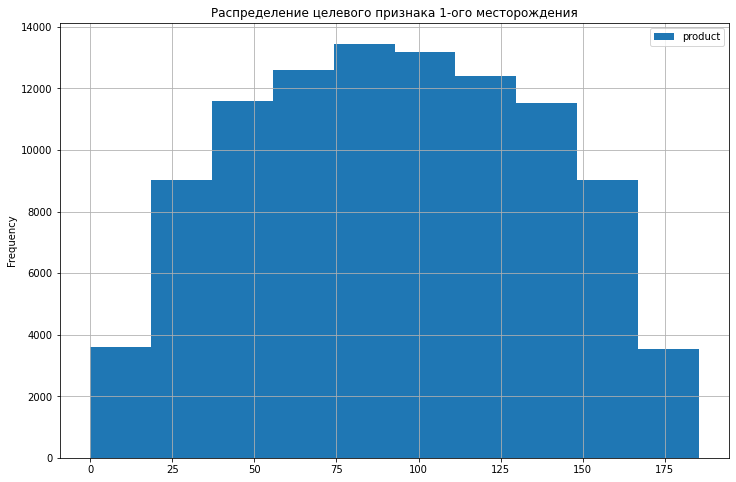

In [12]:
df_0.plot(y='product', kind = 'hist',bins = 10,
         title ='Распределение целевого признака 1-ого месторождения', 
         grid = True, figsize = (12,8));

Распределение похоже на нормальное

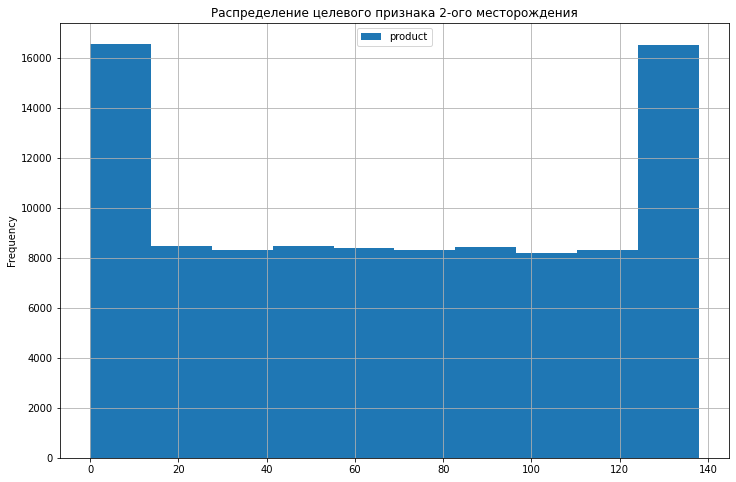

In [13]:
df_1.plot(y='product', kind = 'hist',bins = 10,
         title ='Распределение целевого признака 2-ого месторождения', 
         grid = True, figsize = (12,8));

В данных второго датасета видны выбросы по обоим стронам от ожидаемой середины "колокола", в точках минимума и максимума значений. В дальнейшем это может сказаться на обучении модели.

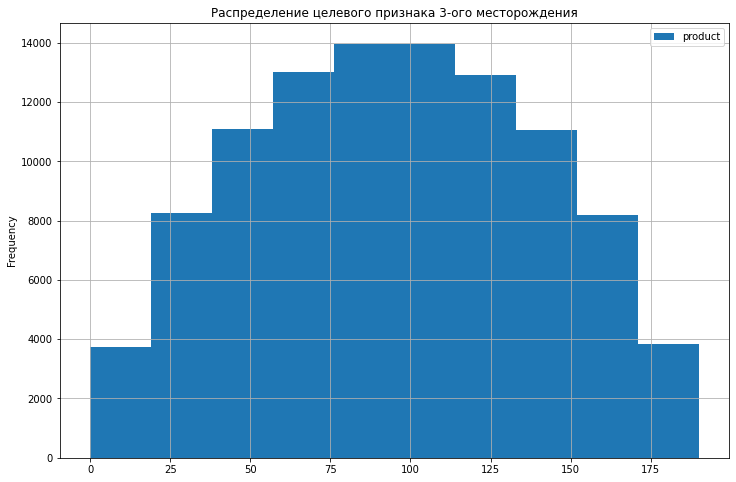

In [14]:
df_2.plot(y='product', kind = 'hist',bins = 10,
         title ='Распределение целевого признака 3-ого месторождения', 
         grid = True, figsize = (12,8));

Распределение величин похоже на нормальное

## Обучение и проверка модели

Целевым признаком в наших выборках будет являться столбец product, остальные столбцы - признаки для обучения модели.

In [15]:
def split(df):
    features = df.drop(['product'],axis=1)
    target = df['product']
    features_train, features_test, target_train, target_test = train_test_split(features,target,
                                                                                  random_state=42,train_size = 0.75)
    return features_train, features_test, target_train, target_test
    

Дополнительных разделений мы делать не будем, т.к. будем использовать кросс-вадидацию.

**Первый датафрейм**

In [16]:
df_0_features_train, df_0_features_test, df_0_target_train, df_0_target_test = split(df_0)
for i in [df_0_features_train, df_0_features_test, df_0_target_train, df_0_target_test]:
    print (i.shape)

(75000, 3)
(25000, 3)
(75000,)
(25000,)


Отлично, первую выборку разделили. Проделаем то же самое с остальными.

**Второй датарейм**

In [17]:
df_1_features_train, df_1_features_test, df_1_target_train, df_1_target_test = split(df_1)
for i in [df_1_features_train, df_1_features_test, df_1_target_train, df_1_target_test]:
    print (i.shape)

(75000, 3)
(25000, 3)
(75000,)
(25000,)


**Третий датафрейм**

In [18]:
df_2_features_train, df_2_features_test, df_2_target_train, df_2_target_test = split(df_2)
for i in [df_2_features_train, df_2_features_test, df_2_target_train, df_2_target_test]:
    print (i.shape)

(75000, 3)
(25000, 3)
(75000,)
(25000,)


Выборки разделены нормально,теперь можно переходить к обучению моделей и кросс-валидации.

### Первый регион

In [19]:
def models(features,target,features_test,target_test,predicted_test):
    #Так так метод cross_val_score по сути старается найти лучшее значение метрики,
    # при этом увеличивается значение RMSE используем костыли
    model = LinearRegression()
    rmse= (np.sqrt(-cross_val_score(model, features,
                                    target,cv=5,scoring='neg_mean_squared_error'))).mean()

    model.fit(features, target)
    predicted_test = model.predict(features_test)
    rmse_0 = mean_squared_error(target_test, predicted_test,squared=False)

    # Посчитаем средний запас месторождений по 1 региону
    predicted_test_mean = predicted_test.mean()

    return model, print(f'Средняя оценка качества модели: {rmse}\
                        \nRMSE для 3-ого региона: {rmse_0}\
                        \nСредний запас месторождений в 1 регионе: {predicted_test_mean}')

IndentationError: unexpected indent (2651401643.py, line 6)

In [ ]:
models(df_0_features_train, df_0_target_train, df_0_features_test,df_0_target_test,predicted_test_0)

In [20]:
model = LinearRegression()
rmse= (np.sqrt(-cross_val_score(model, df_0_features_train,df_0_target_train,cv=5,scoring='neg_mean_squared_error'))).mean()

print('Средняя оценка качества модели:', rmse)


model.fit(df_0_features_train, df_0_target_train)
predicted_test_0 = model.predict(df_0_features_test)
rmse_0 = mean_squared_error(df_0_target_test, predicted_test_0,squared=False)

# Посчитаем средний запас месторождений по 2 региону
predicted_0_test_mean = predicted_test_0.mean()

print("RMSE для 2-ого региона =", rmse_0)
print('Средний запас месторождений во 2 регионе:',predicted_0_test_mean)

Средняя оценка качества модели: 37.67200536313506
RMSE для 2-ого региона = 37.756600350261685
Средний запас месторождений во 2 регионе: 92.3987999065777


Получили сходимость с небольшой погрешностью RMSE на кросс-валидации и при обычном обучении модели. Средний запас скважины в данном регионе равен **92.40** тыс. баррелей

### Второй регион

In [21]:
model = LinearRegression()
rmse= (np.sqrt(-cross_val_score(model, df_1_features_train,df_1_target_train,cv=5,scoring='neg_mean_squared_error'))).mean()

print('Средняя оценка качества модели:', rmse)


model.fit(df_1_features_train, df_1_target_train)
predicted_test_1 = model.predict(df_1_features_test)
rmse_1 = mean_squared_error(df_1_target_test, predicted_test_1,squared=False)

# Посчитаем средний запас месторождений по 2 региону
predicted_1_test_mean = predicted_test_1.mean()

print("RMSE для 2-ого региона =", rmse_1)
print('Средний запас месторождений во 2 регионе:',predicted_1_test_mean)

Средняя оценка качества модели: 0.8904559629285675
RMSE для 2-ого региона = 0.890280100102884
Средний запас месторождений во 2 регионе: 68.71287803913762


Получили сходимость с небольшой погрешностью RMSE на кросс-валидации и при обычном обучении модели,при кросс-валидации погрешность чуть выше. Средний запас скважины в данном регионе равен **68.71** тыс. баррелей

### Третий регион

In [22]:
model = LinearRegression()

rmse= (np.sqrt(-cross_val_score(model, df_2_features_train,df_2_target_train,cv=5,scoring='neg_mean_squared_error'))).mean()
print('Средняя оценка качества модели:', rmse)

model.fit(df_2_features_train, df_2_target_train)
predicted_test_2 = model.predict(df_2_features_test)
rmse_2 = mean_squared_error(df_2_target_test, predicted_test_2,squared=False)

# Посчитаем средний запас месторождений по 3 региону
predicted_2_test_mean = predicted_test_2.mean()

print("RMSE для 3-ого региона:", rmse_2)
print('Средний запас месторождений в 3 регионе:',predicted_2_test_mean)

Средняя оценка качества модели: 40.02698159997838
RMSE для 3-ого региона: 40.14587231134218
Средний запас месторождений в 3 регионе: 94.77102387765939


Получили сходимость с небольшой погрешностью RMSE на кросс-валидации и при обычном обучении модели. Средний запас скважины в данном регионе равен **94.77** тыс. баррелей

### Выводы

- Получили прогнозы по всем трем регионам;
- Как мы видим, самый большой теоретический запас находится **в третьем** регионе, самый малый - **во втором**;
- Самая малое значение **RMSE** мы так же получили  **во втором** регионе, погрешность в котором довольно низка;
- В других двух месторождениях RMSE доходит практически до половины всего запаса месторождений в регионе, это связано с большим разбросом данных и далеким от нормального распределения.
- Скорее всего такое малое значение **RMSE** по второму региону мы получили из-за того, что разброс величин бл компенсирован большим количеством значений в точках минимума и максимума распределения целевого признака.

## Подготовка к расчёту прибыли

Для расчёта точки безубыточности ,требуется для начала определить затраты на одну скважину

Также, по условия задания нам сказано следующее:
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. 
- Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

Для начала определим, какой бюджет заложен на разработку одного месторождения:

In [23]:
BUDGET = 10_000_000_000
budget_per_place = int(BUDGET/200)
print(f'Бюджет на разработку месторождений равен {budget_per_place}')

Бюджет на разработку месторождений равен 50000000


Таким образом, бюджет на разработку - 50 млн. Теперь определим точку безубыточности, исходя из цены нефти.

In [24]:
PRICE = 450_000
profit_point = budget_per_place/0.45
print(f'Точка безубыточности: {profit_point} тыс. баррелей')

Точка безубыточности: 111111111.1111111 тыс. баррелей


> Итого получается, что точкой безубыточности с учетом разработки скважины и цены на нефть будет скважина с объемом равной или более 111 тыс. баррелей. Это больше, чем среднее значение запасов нефти в каждом из регионов.

## Расчёт прибыли и рисков 

Напишем функцию для рассчёта прибыли

In [25]:
def revenue (target,predictions,count):
    prediction_sorted = predictions.sort_values(ascending = False)
    selected = target[prediction_sorted.index][:count]
    return (selected.sum()*PRICE-BUDGET)/1_000_000  

Самое время использовать технику **Bootstrap** для рассчёта рисков убыточности всех выбранных месторождений.

In [26]:
state = np.random.RandomState(12345)

def result (target,predictions):
    values = []
    for i in range(1000):
        target.subsample = target.sample(n=500,replace= True, random_state = state)
        probs_subsample = predictions [target.subsample.index]
        result = revenue(target.subsample,probs_subsample,200)
        values.append(result)
    values = pd.Series(values)
    percentage_neg = (values < 0).mean()*100
    mean = values.mean()
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    print(f'Средняя прогнозируемая прибыль составит {mean} млрд рублей')
    print(f'С вероятностью 95% прогнозируемая прибыль составит от {lower} до {upper} млрд рублей')
    print(f'Риск убыточности месторождения составляет {percentage_neg}%')


### Первый регион

In [27]:
df_0_target_test= df_0_target_test.reset_index(drop= True)
predicted_test_0 = pd.Series(predicted_test_0)
result(df_0_target_test,predicted_test_0)

Средняя прогнозируемая прибыль составит 435.9337721386621 млрд рублей
С вероятностью 95% прогнозируемая прибыль составит от -116.23161277720817 до 966.504180707376 млрд рублей
Риск убыточности месторождения составляет 6.1%


### Второй регион

In [28]:
df_1_target_test= df_1_target_test.reset_index(drop= True)
predicted_test_1 = pd.Series(predicted_test_1)
result(df_1_target_test,predicted_test_1)

Средняя прогнозируемая прибыль составит 498.5690169167883 млрд рублей
С вероятностью 95% прогнозируемая прибыль составит от 75.31557308898354 до 911.5036950245577 млрд рублей
Риск убыточности месторождения составляет 1.0%


### Третий регион

In [29]:
df_2_target_test= df_2_target_test.reset_index(drop= True)
predicted_test_2 = pd.Series(predicted_test_2)
result(df_2_target_test,predicted_test_2)

Средняя прогнозируемая прибыль составит 412.672898988532 млрд рублей
С вероятностью 95% прогнозируемая прибыль составит от -158.9395157636048 до 978.1912017001915 млрд рублей
Риск убыточности месторождения составляет 7.000000000000001%


### Выводы

**Риски убыточности скважин в регионах**

- Самый низкий риск убыточности месторождения *во втором регионе*, он составляет **1%**;
- Самый высокий риск убыточности скважины *в третьем регионе*, - **7%**;
- Риск убыточности *в первом регионе* так же относительно высок - **6,1%**.

**Прогнозируемая прибыль с вероятностью 95% составит:**

- В *первом* регионе от **-116.23161** до **966.50418** млрд рублей;
- Во *втором* регионе от **75.31557** до **911.503695** млрд рублей;
- В *третьем* регионе от **-158.9395157636048** до **978.1912017001915** млрд рублей.

**Средняя прогнозируемая прибыль составит:**

- В *первом* регионе **435.9337721386621** млрд рублей;
- Во *втором* регионе **498.5690169167883** млрд рублей;
- В *третьем* регионе **412.672898988532** млрд рублей.

